<a href="https://colab.research.google.com/github/wkweigel/NotebookExamples/blob/main/VinaDocking.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This is a simple docking workflow using autodock vina.

* Use for docking ligands into areas occupied by native co-crystallized ligands.

General process:
1. Fetch a PDB entry with a bound ligand using a PDB ID.
  * For PDB entries containing two or more ligands, you will also need the specifiy the ligand ID for the area you want to dock into.
2. Use the ligand position to auto generate gridbox coords for Vina to use.
3. Perform docking using Autodock Vina.
4. Show docking results.
5. Show specific docking interactions using Prolif.



#Notebook Setup
Install main packages using conda and pip

* (This can take a few minutes to complete, click restart when prompted and continue)

---



In [1]:
#Install condacolab
!pip install -q condacolab
import condacolab
condacolab.install()

#Install pymol, openbabel and other packages
!mamba install -c conda-forge pymol-open-source openbabel openmm pdbfixer vina prolif
#!mamba install conda-forge::vina

#Install rdkit and other packages
!pip install rdkit tqdm MDAnalysis py3Dmol ipython LigPrepper meeko



⏬ Downloading https://github.com/conda-forge/miniforge/releases/download/23.11.0-0/Mambaforge-23.11.0-0-Linux-x86_64.sh...
📦 Installing...
📌 Adjusting configuration...
🩹 Patching environment...
⏲ Done in 0:00:17
🔁 Restarting kernel...

Looking for: ['pymol-open-source', 'openbabel', 'openmm', 'pdbfixer', 'vina', 'prolif']

[+] 0.0s
conda-forge/linux-64  ⣾  
conda-forge/noarch    ⣾  [+] 0.1s
conda-forge/linux-64  ⣾  
conda-forge/noarch    ⣾  [+] 0.2s
conda-forge/linux-64   1%
conda-forge/noarch    10%[+] 0.3s
conda-forge/linux-64  12%
conda-forge/noarch    20%[+] 0.4s
conda-forge/linux-64  16%
conda-forge/noarch    39%[+] 0.5s
conda-forge/linux-64  20%
conda-forge/noarch    49%[+] 0.6s
conda-forge/linux-64  25%
conda-forge/noarch    59%[+] 0.7s
conda-forge/linux-64  29%
conda-forge/noarch    68%[+] 0.8s
conda-forge/linux-64  33%
conda-forge/noarch    68%[+] 0.9s
conda-forge/linux-64  33%
conda-forge/noarch    78%[+] 1.0s
conda-forge/linux-64  37%
conda-forge/noarch    78%[+] 1.1s
conda-

Clone the NotebookExample repository for access to vina utilities

In [1]:
import sys

#Clone main repository into colab
!git clone https://github.com/wkweigel/NotebookExamples.git

#Add the main directory to the path
main_dir = '/content/NotebookExamples/VinaExamples'
sys.path.insert(0,f'{main_dir}/')

#Import vina utililiy functions
from VinaUtils import *

Cloning into 'NotebookExamples'...
remote: Enumerating objects: 234, done.
remote: Counting objects: 100% (118/118), done.
remote: Compressing objects: 100% (116/116), done.
remote: Total 234 (delta 69), reused 0 (delta 0), pack-reused 116 (from 1)
Receiving objects: 100% (234/234), 14.52 MiB | 10.31 MiB/s, done.
Resolving deltas: 100% (122/122), done.


Import libraries

In [2]:
from pymol import cmd
import py3Dmol
import pandas as pd
import random
from openbabel import pybel
import prolif as plf
import MDAnalysis as mda
from MDAnalysis.coordinates import PDB
from MDAnalysis import Merge
from LigPrepper import pdbqt2sdf
from meeko import MoleculePreparation

import math, os, random, warnings
import numpy as np
from matplotlib import cm, colors
from matplotlib import pyplot as plt
from pathlib import Path

from rdkit import Chem
from rdkit.Chem import AllChem, Draw, rdDistGeom
from rdkit.Geometry import Point3D

from vina import Vina

from IPython.display import IFrame
warnings.filterwarnings("ignore")

%config Completer.use_jedi = False



#Docking Setup
Specify Inputs
* Here we are using SIRT6 in complex with Quercetin ([6QCD](https://https://www.rcsb.org/structure/6QCD))
* The smiles for two other SIRT6 binders will be used for docking: catechin gallate and MDL-801

In [3]:
#The PDB ID to fetch and prepare
pdbID='6QCD'

#The smiles of the molecules to dock
docking_smiles = ['c1cc(c(cc1[C@@H]2[C@H](Cc3c(cc(cc3O2)O)O)OC(=O)c4cc(c(c(c4)O)O)O)O)O', '	Cc1cc(c(cc1NS(=O)(=O)c2ccc(cc2C(=O)O)NS(=O)(=O)c3cc(cc(c3)Cl)Cl)Br)F']


Fetch and prepare protien from the PDB
* Note: Thid PDB entry for SIRT6 also is bount to ADP-ribose.
  * We pass the ligID parameter "QUE" to the fetchPDB function, otherwise it will return the structure with both Qerecetin, ADP-ribose, and solvent (try removing this parameter if you want to see all the bound organic small molecules).
  * You can see the ligand IDs for the PDB entry under the 'Small Molecules" section on the PDB website.

In [49]:
#Create directories for the current project if they dont exist
PDB_Folder=f'/content/{pdbID}'
Results_Folder=f'{PDB_Folder}/Results'

Path(PDB_Folder).mkdir(parents=True, exist_ok=True)
Path(Results_Folder).mkdir(parents=True, exist_ok=True)

#Fetch files from the PDB and store in the created project folder
receptor_pdb, ligand_pdb, ligand_mol2=fetchPDB(PDB_Folder, pdbID, ligID='QUE')

#Show the receptor and the specified ligand
preview_receptor(receptor_pdb,ligand_pdb)

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

Get the gridbox coords for the area around the ligand

In [50]:
center, size=calc_gridbox(receptor_pdb,ligand_pdb)
preview_gridbox(receptor_pdb, ligand_pdb, center, size)

Center: {'center_x': -23.9060001373291, 'center_y': 26.01099967956543, 'center_z': 19.761500358581543}
Size: {'size_x': 14.220001220703125, 'size_y': 20.450000762939453, 'size_z': 14.439001083374023}


3Dmol.js failed to load for some reason. Please check your browser console for error messages.

Create and save pdbqt files for the protein and ligand that will be used for docking

In [8]:
#Define the names to be used for the output pdbqt files
receptor_pdbqt=f'{PDB_Folder}/{pdbID}_clean.pdbqt'
ligand_pdbqt=f'{PDB_Folder}/{pdbID}_NativeLigand.pdbqt'

#Convert the pdb files with openbabel
!obabel -ipdb {receptor_pdb} -opdbqt -xr -O {receptor_pdbqt}
!obabel -ipdb {ligand_pdb} -opdbqt -O {ligand_pdbqt}

*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders (title is /content/6QCD/6QCD_clean.pdb)

1 molecule converted
1 molecule converted


#Vina Docking

Perform docking of the provided smiles (catechin gallate and MDL-801)

* With colab, this takes about 3 mins per compound using low exhaustiveness (8) and few poses (5).  

In [9]:

v = Vina(sf_name='vina')

#Set the receptor in vina
v.set_receptor(receptor_pdbqt)

#Make the gridmaps
v.compute_vina_maps(center=list(center.values()), box_size=list(size.values()))



for idx, smiles in enumerate(docking_smiles) :
    #create rdkit mol object from smiles
    mol = Chem.MolFromSmiles(smiles)

    #add polar Hydrogens to mol
    mol_H = Chem.AddHs(mol)

    #Embed the mol for use in meeko
    lig_mol=get_real_conformer(mol_H) #Guarentees the conformer generation is successful. Useful for ligands with many fixed and rotatable bonds.
    print('Conformer generation successful.')
    print(f'Docking ligand {idx + 1}...')
    #prepare the mol in meeko
    prep = MoleculePreparation()
    mol_prep = prep.prepare(lig_mol)

    #write the final pdbqt string for use in vina
    pdbqt_string = prep.write_pdbqt_string()
    #pdbqt_string = PDBQTWriterLegacy.write_string(mol_prep)

    #Set the ligand in vina
    v.set_ligand_from_string(pdbqt_string)
    #v.set_ligand_from_file(pdbqt_string)

    pdbqt_output = f'{Results_Folder}/{pdbID}_{idx}_vina_out.pdbqt'
    sdf_output = f'{Results_Folder}/{pdbID}_{idx}_vina_out.sdf'

    #dock the ligand
    v.dock(exhaustiveness=8, n_poses=5)

    #Save the docked poses to file
    v.write_poses(pdbqt_output, n_poses=5, overwrite=True)
    !mk_export.py {pdbqt_output} -o {sdf_output}

1 failed conformer generations. Reattempting...
Conformer generation successful.
Docking ligand 1...
1 failed conformer generations. Reattempting...
Conformer generation successful.
Docking ligand 2...


Show the docking results for all the poses of the specified ligand

In [51]:
#The index from the smiles to view the poses for
ligand_idx=0

#Split the vina_out file into seperate pdbqt files (sdf files will also be created)
vina_pdbqt_output = f'{Results_Folder}/{pdbID}_{ligand_idx}_vina_out.pdbqt'
split_vina_output(vina_pdbqt_output)

#Visulize the docking poses
view_vina_results(receptor_pdb,vina_pdbqt_output,ligand_pdb)

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

Show the docking results for a single pose

In [52]:
#The index from the specific pose to view
pose=2

#Visulize the specified docking pose
view_vina_pose(receptor_pdb,vina_pdbqt_output, pose, ligand_pdb)

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

# Prolif (Protein Ligand Interaction Fingerprint) Analysis
Use MDAnalysis to create protein and ligand objects that will be used by prolif

[19:32:38] Explicit valence for atom # 0 N, 4, is greater than permitted


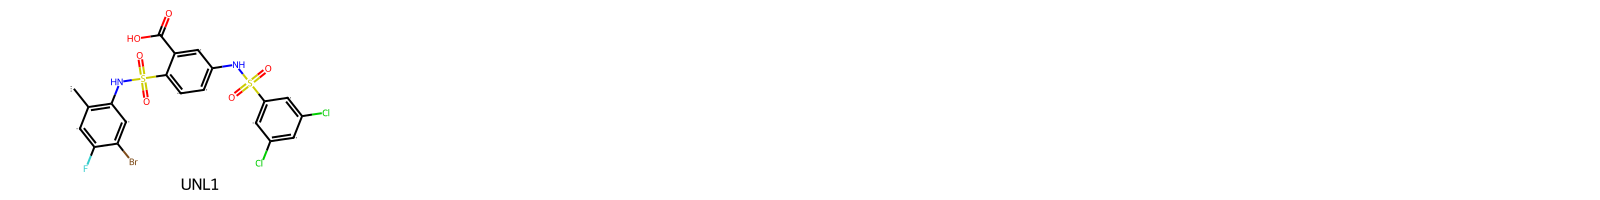

In [13]:
fix_protein(filename=f'{PDB_Folder}/{pdbID}_clean.pdb',addHs_pH=7.4,try_renumberResidues=True,output=f'{PDB_Folder}/{pdbID}_clean_fix.pdb')

DockingResult = f'{Results_Folder}/{pdbID}_{ligand_idx}_vina_out_pose_{pose}.sdf'

# load fixed protein
prot = mda.Universe(f'{PDB_Folder}/{pdbID}_clean_fix.pdb')
protein_mol = plf.Molecule.from_mda(prot,NoImplicit=False)
protein_mol.n_residues

# load ligands
ligand_mol = plf.sdf_supplier(DockingResult)[0]

# display ligand
plf.display_residues(ligand_mol, size=(400, 200))

Perform fingerprinting

In [33]:
ligand_idx = 0 #The index from the smiles list to fingerprint

#Set path to the sdf file containing vina docking poses
vina_sdf = f'{Results_Folder}/{pdbID}_{ligand_idx}_vina_out.sdf'

#Create pose iterable from vina_sdf using the prolif sdf supplier
pose_iterable = plf.sdf_supplier(vina_sdf)

#Specify interactions to use for fingerprinting
fp = plf.Fingerprint(["Hydrophobic", "HBDonor", "HBAcceptor", "PiStacking", 'Cationic', 'Anionic', 'VdWContact'])

# Fingerprint interactions for all poses
fp.run_from_iterable(pose_iterable, protein_mol, n_jobs=1) #n_jobs must be set to 1 for colab.




  0%|          | 0/5 [00:00<?, ?it/s]

<prolif.fingerprint.Fingerprint: 7 interactions: ['Hydrophobic', 'HBAcceptor', 'HBDonor', 'Cationic', 'Anionic', 'PiStacking', 'VdWContact'] at 0x7eaac3cf1c30>

View interactions (2D view)

In [34]:
#Show interactions for the specified pose
pose_idx = 0

# Display the results in 2D for the specified pose index
view = fp.plot_lignetwork(pose_iterable[0])
view

View interactions (3D view)

In [36]:
#Show interactions for the specified pose
pose_idx = 0

fp_count = plf.Fingerprint(count=True)
fp_count.run_from_iterable(pose_iterable, protein_mol, n_jobs = 1)
view = fp_count.plot_3d(pose_iterable[pose_index], protein_mol, frame=pose_index, display_all=False)
view.PROTEIN_STYLE = {'cartoon':{'arrows':False, 'tubes':False, 'style':'oval', 'opacity':0.5,'color':'white'}}

view

  0%|          | 0/5 [00:00<?, ?it/s]

3Dmol.js failed to load for some reason. Please check your browser console for error messages.